In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from pygam import LinearGAM
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

## Przegląd danych

In [3]:
seed = 20

df = pd.read_stata('../data/HCMST 2017 fresh sample for public sharing draft v1.1.dta')
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Wybrane zmienne

* Numeryczne
    * age_when_met 
    * time_from_met_to_rel
<br><br>
* Kategoryczne
    * ppagecat
    * ppincimp

In [4]:
num_feature1 = 'age_when_met'  # age when met in years,
num_feature2 = 'time_from_met_to_rel'  # Time from meeting to relationship
cat_feature1 = 'ppagecat'  # Age - 7 Categories
cat_feature2 = 'ppincimp'  # Household Income 
label = 'S1'  # Are you married?

#### Zakodowanie danych kategorycznych

In [5]:
incomes = [
    'Less than $5,000',
    '$5,000 to $7,499',
    '$7,500 to $9,999',
    '$10,000 to $12,499', 
    '$12,500 to $14,999',
    '$15,000 to $19,999',
    '$20,000 to $24,999',
    '$25,000 to $29,999',
    '$30,000 to $34,999',
    '$35,000 to $39,999',
    '$40,000 to $49,999',
    '$50,000 to $59,999',
    '$60,000 to $74,999',
    '$75,000 to $84,999',
    '$85,000 to $99,999',
    '$100,000 to $124,999', 
    '$125,000 to $149,999', 
    '$150,000 to $174,999', 
    '$175,000 to $199,999', 
    '$200,000 to $249,999', 
    '$250,000 or more',      
]

ages = [
    '18-24', 
    '25-34', 
    '35-44', 
    '45-54', 
    '55-64', 
    '65-74', 
    '75+'
]

income_encoder = {inc: i for i, inc in enumerate(incomes)}
age_encoder = {age: i for i, age in enumerate(ages)}

In [6]:
df = df[[num_feature1, num_feature2, cat_feature1, cat_feature2, label]]
df = df.dropna()

df[cat_feature1] = df[cat_feature1].apply(lambda x: age_encoder[x]).astype(np.int)
df[cat_feature2] = df[cat_feature2].apply(lambda x: income_encoder[x]).astype(np.int) 
df[label] = df[label].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
df.head()

,age_when_met,time_from_met_to_rel,ppagecat,ppincimp,S1
0,30.0,0.000000,1,10,0
1,21.0,12.250000,4,17,1
2,36.0,0.416748,3,19,1
3,23.0,1.083252,1,10,0
4,25.0,0.083252,4,18,1


#### Podział na zbiory - treningowy i testowy

In [7]:
X = df.drop(label, axis=1)
y = df[label]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=seed)

## Trening i walidacja modelu

In [8]:
models = {
    'xgboost': xgb.sklearn.XGBClassifier(learning_rate=0.01, n_estimators=300, reg_lambda=9,  n_jobs=-1, random_state=seed),
    'svm': SVC(C=2, gamma='scale', probability=True),
    'logistic_regression': LogisticRegression(solver='lbfgs')
}

for name, model in models.items():
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    score = accuracy_score(pred_y, test_y)
    print(f'Accuracy: {(score*100):.2f}% - {name}')

Accuracy: 77.82% - xgboost
Accuracy: 76.96% - svm
Accuracy: 77.45% - logistic_regression


### Wyliczenie reszt na zbiorze uczącym

In [9]:
all_residuals = {}
for name, model in models.items():
    preds = model.predict_proba(train_X)[:, 1]
    all_residuals[name] = train_y.values - preds

#### Boxplot dla reszt poszczególnych modeli

([<matplotlib.axis.XTick at 0x7f86911d12b0>,
 <a list of 3 Text xticklabel objects>)

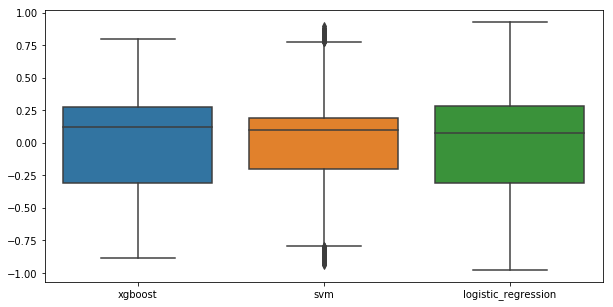

In [10]:
names = list(all_residuals.keys())
res = list(all_residuals.values())

plt.figure(figsize=(10, 5))
sns.boxplot(data=res)
plt.xticks(range(len(names)), names)

#### Wykres ilości reszt większych od ustalonej wartości

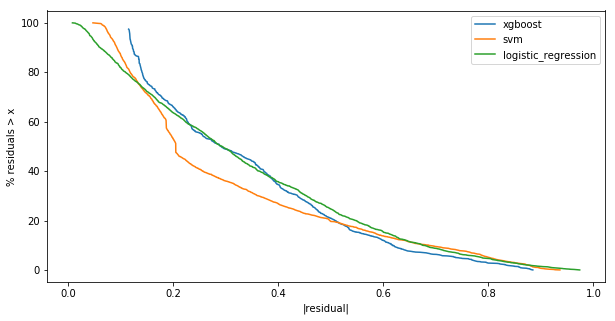

In [11]:
plt.figure(figsize=(10, 5))
for name, res in all_residuals.items():
    res = sorted(np.abs(res))
    f = [np.mean(res > r)*100 for r in res]
    plt.plot(res, f, label=name)
    
plt.legend()
plt.xlabel('|residual|')
plt.ylabel('% residuals > x')
plt.show()

### Funkcje to tworzenia wykresów

In [12]:
def smooth(x, y):
    gam = LinearGAM().fit(x, y)
    XX = gam.generate_X_grid(term=0, n = 1000)
    smooth_index = XX > 0
    x_smooth = XX[smooth_index]
    y_smooth = gam.partial_dependence(term=0, X=XX)[smooth_index.flatten()]
    return x_smooth, y_smooth


def residual_per_prediction(model, X, y, ax=None):
    if ax is None:
        ax = plt.axes()
    m_name, model = model
    preds = model.predict_proba(X)[:, 1] 
    residuals = y.values - preds
    idx = np.argsort(preds)
    preds, residuals = preds[idx], residuals[idx]
    smooth_x, smooth_y = smooth(preds, residuals)
    ax.scatter(preds, residuals)
    ax.plot(smooth_x, smooth_y, 'r--')
    ax.plot([min(preds), max(preds)], [0, 0], 'k:')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Residual')
    ax.set_title(m_name)
    
    
def residual_per_feature(model, X, y, feature, ax=None):
    if ax is None:
        ax = plt.axes()
    m_name, model = model
    preds = model.predict_proba(X)[:, 1] 
    residuals = y.values - preds
    fcol = X[feature].values
    idx = np.argsort(fcol)
    fcol, residuals = fcol[idx], residuals[idx]
    smooth_x, smooth_y = smooth(fcol, residuals)
    ax.scatter(fcol, residuals)
    ax.plot(smooth_x, smooth_y, 'r--')
    ax.plot([min(fcol), max(fcol)], [0, 0], 'k:')
    ax.set_xlabel(feature)
    ax.set_ylabel('Residual')
    ax.set_title(m_name)
    
    
def cook_plot(model, X, y, ax=None):
    if ax is None:
        ax = plt.axes()
    m_name, model = model
    model.fit(X, y)
    preds = model.predict_proba(X)[:, 1]
    
    inference = []
    for i, row in tqdm(X.iterrows(), total=len(X)):
        dX = X.drop(i)
        dy = y.drop(i)
        model.fit(dX, dy)
        d_preds = model.predict_proba(X)[:, 1]
        inf = np.sqrt(np.mean((preds - d_preds)**2))
        inference.append(inf)
    
    ax.scatter(range(len(inference)), inference)
    ax.set_xlabel('n. observation')
    ax.set_xlabel('Inference')
    ax.set_title(m_name)

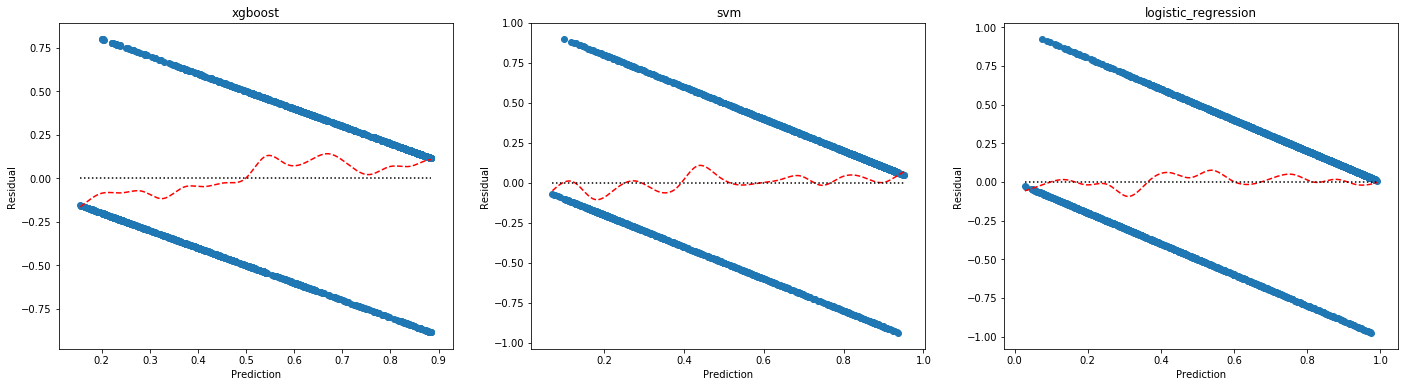

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
for model, ax in zip(models.items(), axes):
    residual_per_prediction(model, train_X, train_y, ax)

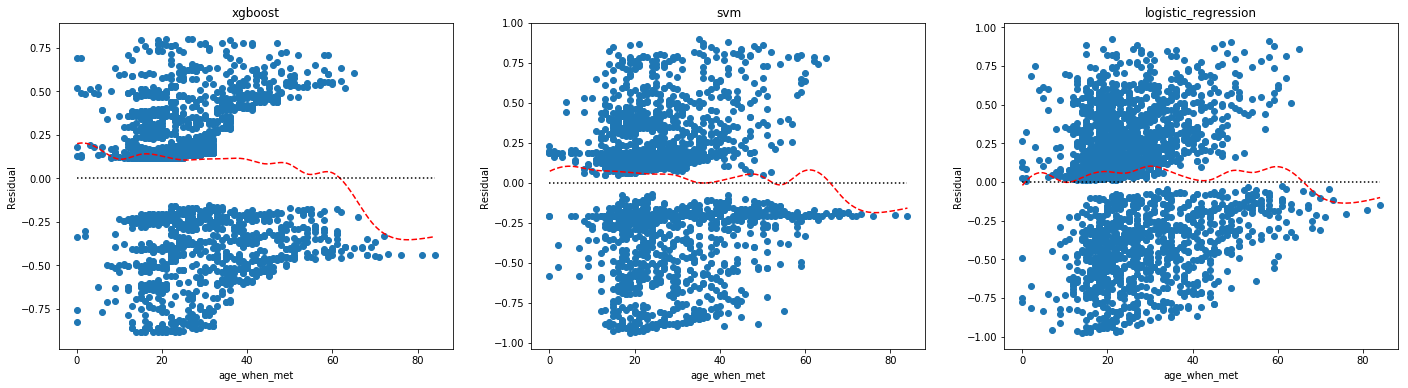

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
for model, ax in zip(models.items(), axes):
    residual_per_feature(model, train_X, train_y, 'age_when_met', ax)

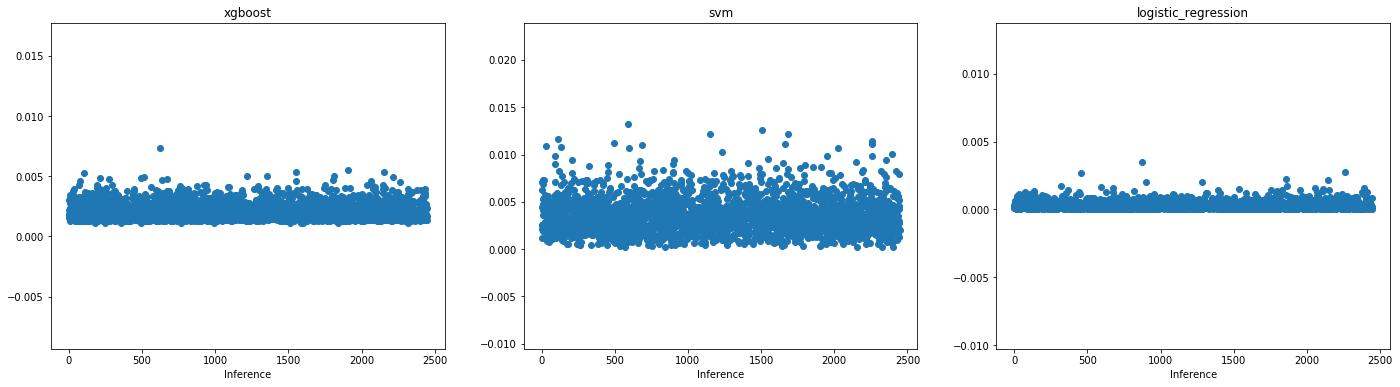

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
for model, ax in zip(models.items(), axes):
    cook_plot(model, train_X, train_y, ax)

### Wnioski

Do analizy wybrałem zmienne:
* age_when_met 
* time_from_met_to_rel
* ppagecat
* ppincimp

Wytrenowałem na nich 3 modele (svm, xgboost, logistic regression), przy czym wszystkie wykazały się bardzo podobnym accuracy w okolicach 77%.
* Accuracy: 77.82% - xgboost
* Accuracy: 76.96% - svm
* Accuracy: 77.45% - logistic_regression

#### Rozkład reszt
Na wykresach opisujących reszty można zauważyć, że reszty w przypadku SVM są często bardziej zbliżone do 0 niż w przypadku 2 pozostałych modeli. Boxplot jest wyraźnie węższy oraz widać szybszy spadek na wykresie pokazującym ilość reszt większych od danej wartości (różnica ta wyrównuje się w okolicach 0.5).

#### Zależność reszt od predykcji
Tutaj wykresy wyglądają dość podobnie. XGBoost wyraźnie zmienia trend pomyłek z ujemnych na dodatnie w okolicach 0.5. SVM i regresja logistyczna są bardziej zbliżone do idealnej linii na poziomie 0.

#### Zależność reszt od wieku spotkania
W tym przypadku każdy model wyraźnie myli się dla wieku ponad 60 lat w stronę niższego prawdopodobieństwa bycia w związku małżeńskim. Natomiast przed tą granicą średnio zawyża to prawdopodobieństwo. Również największe wahania występują w przypadku modelu XGBoost.

#### Wartości Cooka
Z analizy wartości Cooka dla poszczególnych modeli wynika, że najbardziej stabilna jest regresja logistyczna, następnie XGBoost, a najgorzej wypada SVM.